### Crust 1.0 data

Crust 1.0 is built on a regular grid — it is also wrapped in the `litho1pt0` module 

In [1]:
import gdal
import litho1pt0 as litho
import numpy as np

In [2]:
# The full descriptions of the numbers in the table
print(litho.c1_region_descriptor )

# The table of data
crust_type = litho._c1_crust_type_lat_lon 
print("Resolution: ", crust_type.shape)
print(crust_type)

['Platform', 'Slow, thin Platform', 'Archean (Antarctica)', 'Early Archean', 'Late Archean', 'Early/mid  Proter.,', 'Early/mid  Proter. (Antarctica, slow)', 'Late Proter.', 'Slow late Proter.', 'Island arc', 'Forearc', 'Continental arc', 'Slow continental arc', 'Extended crust', 'Fast extended crust (Antarctica)', 'Orogen (Antarctica), thick upper, thin lower crust', 'Orogen, thick upper crust, very thin lower crust', 'Orogen, thick upper crust, fast middle crust', 'Orogen with slow lower crust (Andes)', 'Slow orogen (Himalaya)', 'Margin-continent/shield  transition', 'Slow Margin/Shield (Antarctica)', 'Rift', 'Phanerozoic', 'Fast Phanerozoic (E. Australia, S. Africa, N. Siberia)', 'Normal oceanic', 'Oceans 3 Myrs and younger', 'Melt affected o.c. and oceanic plateaus', 'Continental shelf', 'Continental slope, margin, transition', 'Inactive ridge, Alpha Ridge', 'Thinned cont. crust, Red Sea', 'Oceanic plateau with cont. crust', 'Caspian depression', 'Intermed. cont./oc. crust, Black Se

In [3]:
gridlonv, gridlatv = np.meshgrid(np.linspace(0,360,720), np.linspace(-90,90,360), sparse=False, indexing='xy')

crust_type_i = np.empty_like(gridlonv, dtype=int)

In [4]:
for i in range(0, gridlonv.shape[0]):
    for j in range(0, gridlonv.shape[1]):
        crust_type_i[i,j]= litho.crust_type_at(lon=gridlonv[i,j], lat=gridlatv[i,j])

In [5]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors


global_extent     = [-180.0, 180.0, -89, 89]

projection1 = ccrs.Orthographic(central_longitude=140.0, central_latitude=0.0, globe=None)
projection2 = ccrs.Mollweide()
projection3 = ccrs.Robinson()

base_projection = ccrs.PlateCarree()

The following code checks to see if the ETOPO1 dataset has been downloaded and has a valid checksum. If not, the dataset will be retrieved from the NOAA website. The size of the dataset is 320 Mb which means it is too large to bundle with this package. 

In [6]:
## Grab the ETOPO1 dataset if it does not already exist

import os
import requests
import sys
import shutil
import time

etopo_file = "Data/ETOPO1_Ice_c_geotiff.tif"
etopo_zip_file = etopo_file + ".zip"
md5="c99943686e1353594ba67996f650a1c3"
md5_zip="fbd0478d0974ca433cdd5cb3530d0d48"
valid=False

if os.path.isfile(etopo_file):
    
    import hashlib
    from functools import partial

    def md5sum(filename):
        with open(filename, mode='rb') as f:
            d = hashlib.md5()
            for buf in iter(partial(f.read, 4096), b''):
                d.update(buf)
        return d.hexdigest()

    if md5sum(etopo_file) == md5:
        valid = True
    else:
        os.remove(etopo_file)
        
if not valid:
     
    print("Need to download ETOPO1 dataset")
    
    url="https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/cell_registered/georeferenced_tiff/ETOPO1_Ice_c_geotiff.zip"
    expected_size="320Mb"

    r = requests.get(url, stream=True)

    start_time = time.time()
    last_time = start_time
    datasize = 0

    with open(etopo_zip_file, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1000000): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
                datasize += len(chunk)
                if (time.time() - last_time) > 2.5:
                    print("{:.1f} Mb in {:.1f}s / {}".format(datasize / 1.0e6, time.time() - start_time, expected_size))
                    last_time = time.time()
 
    import zipfile

    with zipfile.ZipFile(etopo_zip_file) as zf:
            zf.extractall("Data")
            print ("Unzipped {}".format(etopo_zip_file))

In [7]:
ls Data

ETOPO1_Ice_c_geotiff.tif      global_age_data.3.6.z.npz
ETOPO1_Ice_g_geotiff.tif.zip


In [8]:
## Background image


globaletopo = gdal.Open("Data/ETOPO1_Ice_c_geotiff.tif")
globaletopo_img   = globaletopo.ReadAsArray()[::30,::30]
del globaletopo

from matplotlib.colors import LightSource, Normalize

cmap=plt.cm.Greys
ls = LightSource(315, 45)
hillshade = ls.shade(globaletopo_img, cmap, vert_exag=0.0005)



In [9]:
%matplotlib inline
from matplotlib import colors

crust1pt0_clist = [
# Platforms 
    "#6666ff",   
    "#b3b3ff",   
    
# Archean / Proterozoic    
    "#003366", 
    "#003366", 
    "#004d99", 
    "#0066cc", 
    "#0066cc", 
    "#0080ff", 
    "#4da6ff", 

# Arcs
    "#b30000",
    "#e60000",   
    "#ff6666",
    "#ff9999",   

# Extended crust
    "#00cc88",
    "#00cc88",   

# Orogens
    "#ff751a",
    "#ff6600",   
    "#ff8533",
    "#b34700",
    "#ff9933",   
    
# Margin
    "#e6e600",   # <- C. Margin
    "#6666ff",


# Rifted and Extended    
    "#66ff99",   # 3 Rifted / extended

# Phanerozoic
    "#009999",
    "#00e6e6",   
  
# Oceans and plateau
    "#BBBBBB",
    "#BBBBBB",
    "#BBBBBB",
    "#e6e600",  # <-- Shelf
    "#b3b300",  # <-- C. Slope

    
# Other 
    "#BBBBBB",
    "#BBBBBB",
    "#cccca3",   # <- oceanic plateau / continental
    "#BBBBBB",
    "#BBBBBB",
    "#BBBBBB"    # 6 other
]


# map the image with the colors

crust_color_image = np.empty((crust_type_i.shape+(3,)))

for i in range(0,crust_type_i.shape[0]):
    for j in range (0,crust_type_i.shape[1]):
        crust_color_image[i,j] = colors.hex2color(crust1pt0_clist[crust_type_i[i,j]])
        

In [10]:
crust_color_image2 = np.flipud(crust_color_image)

In [11]:
crust_color_image = crust_color_image2**0.333 * hillshade[:,:,0:3]

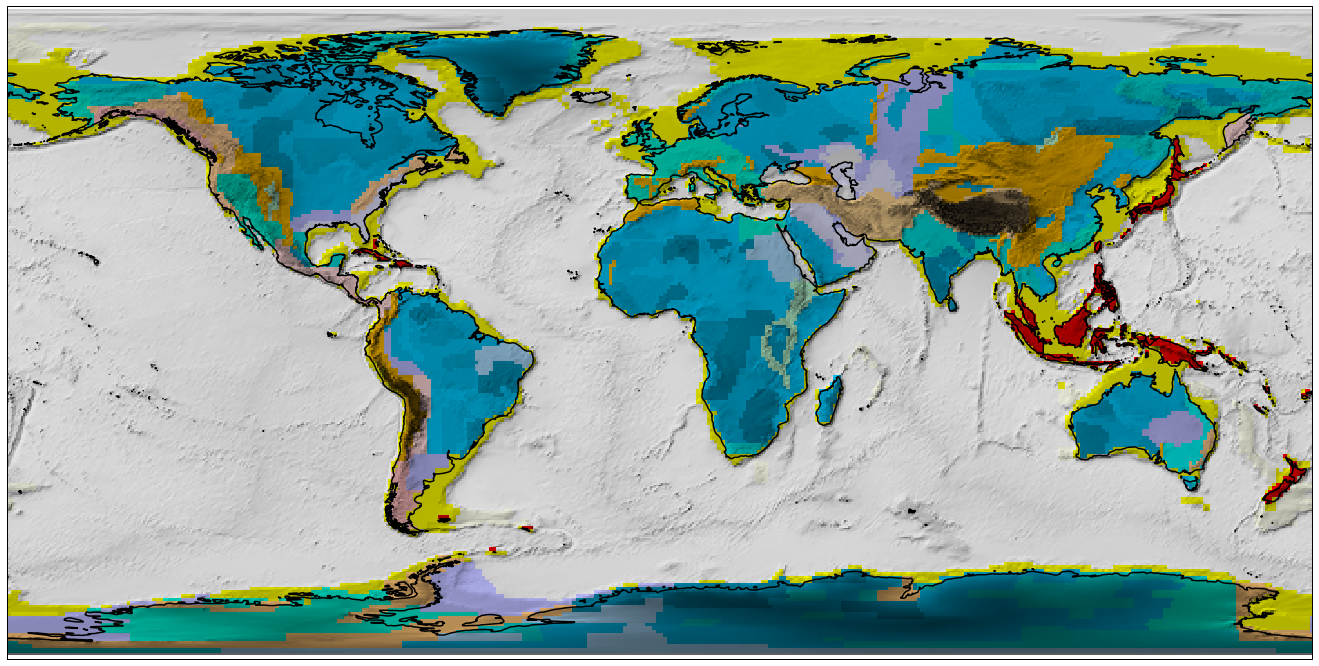

In [12]:
fig = plt.figure(figsize=(24, 12), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.PlateCarree())

# colormap = plt.cm.get_cmap(Crust1pt0, 36)

ax.set_global()

ax.imshow(crust_color_image, origin='upper', transform=base_projection,
          extent=global_extent, zorder=0)


#ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#BBBBBB")
ax.coastlines(resolution="50m", zorder=100, linewidth=1.5)

# fig.savefig("Crust1.0-Regionalisation.png", dpi=300)

In [13]:
for i, desc in enumerate(litho.c1_region_descriptor):
    print("\t {:2d}: {}".format(i,desc))


	  0: Platform
	  1: Slow, thin Platform
	  2: Archean (Antarctica)
	  3: Early Archean
	  4: Late Archean
	  5: Early/mid  Proter.,
	  6: Early/mid  Proter. (Antarctica, slow)
	  7: Late Proter.
	  8: Slow late Proter.
	  9: Island arc
	 10: Forearc
	 11: Continental arc
	 12: Slow continental arc
	 13: Extended crust
	 14: Fast extended crust (Antarctica)
	 15: Orogen (Antarctica), thick upper, thin lower crust
	 16: Orogen, thick upper crust, very thin lower crust
	 17: Orogen, thick upper crust, fast middle crust
	 18: Orogen with slow lower crust (Andes)
	 19: Slow orogen (Himalaya)
	 20: Margin-continent/shield  transition
	 21: Slow Margin/Shield (Antarctica)
	 22: Rift
	 23: Phanerozoic
	 24: Fast Phanerozoic (E. Australia, S. Africa, N. Siberia)
	 25: Normal oceanic
	 26: Oceans 3 Myrs and younger
	 27: Melt affected o.c. and oceanic plateaus
	 28: Continental shelf
	 29: Continental slope, margin, transition
	 30: Inactive ridge, Alpha Ridge
	 31: Thinned cont. crust, Red Sea

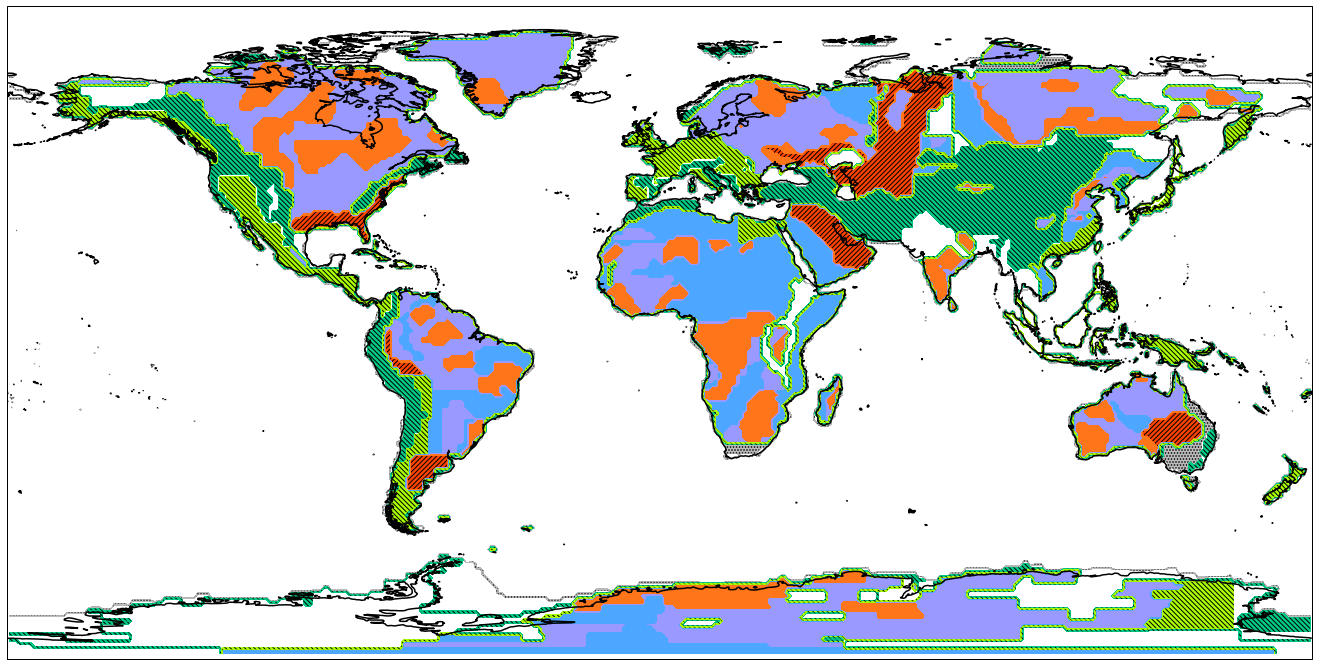

In [14]:
fig = plt.figure(figsize=(24, 12), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.PlateCarree())

# colormap = plt.cm.get_cmap(Crust1pt0, 36)

ax.set_global()

# cmap = plt.get_cmap("Crust1pt0")
# ax.imshow(crust_color_image, origin='upper', transform=base_projection,
#           extent=global_extent, zorder=0, interpolation="lanczos")


# Platforms, Archean, Proterozoic

ax.contourf(crust_type, origin='upper', levels=[0.0, 1.5, 4.5, 6.5, 8.5], 
                colors=[ "#FF4400", "#ff751a", "#9999FF", "#4da6ff"], 
                hatches=["/////", "", "", ""],
                extent=global_extent, transform=base_projection)


# Phanerozoic

ax.contourf(crust_type, origin='upper', levels=[23.0, 24.9], 
                colors=[ "#BBBBBB"], 
                hatches=["....", "", "", ""],
                extent=global_extent, transform=base_projection)


# Orogens

ax.contourf(crust_type, origin='upper', levels=[15.0,20.0], 
                colors=[ "#00cc88", ], 
                hatches=["\\"*5, "", "", ""],
                extent=global_extent, transform=base_projection)

# Arcs

ax.contourf(crust_type, origin='upper', levels=[9.0,13.0], 
                colors=[ "#AAFF00", ], 
                hatches=["\\"*5, "", "", ""],
                extent=global_extent, transform=base_projection)



#ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#BBBBBB")
ax.coastlines(resolution="50m", zorder=100, linewidth=1.5)

# fig.savefig("Crust1.0-Regionalisation.png", dpi=300)